In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

from pathlib import Path
import os.path

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-01 16:10:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-01 16:10:30 (104 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [ ]:
# Load and Transform Data
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)


In [ ]:
dataset = "/content/drive/MyDrive/dataset/cucumber_disease"
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r"**/*.jpg"))+list(image_dir.glob(r"**/*.JPG"))

labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = "Filepath").astype(str)
labels = pd.Series(labels, name = 'Label')

image_df = pd.concat([filepaths, labels], axis = 1)

In [ ]:
image_df['Filepath'].head()

0    /content/drive/MyDrive/dataset/cucumber_diseas...
1    /content/drive/MyDrive/dataset/cucumber_diseas...
2    /content/drive/MyDrive/dataset/cucumber_diseas...
3    /content/drive/MyDrive/dataset/cucumber_diseas...
4    /content/drive/MyDrive/dataset/cucumber_diseas...
Name: Filepath, dtype: object

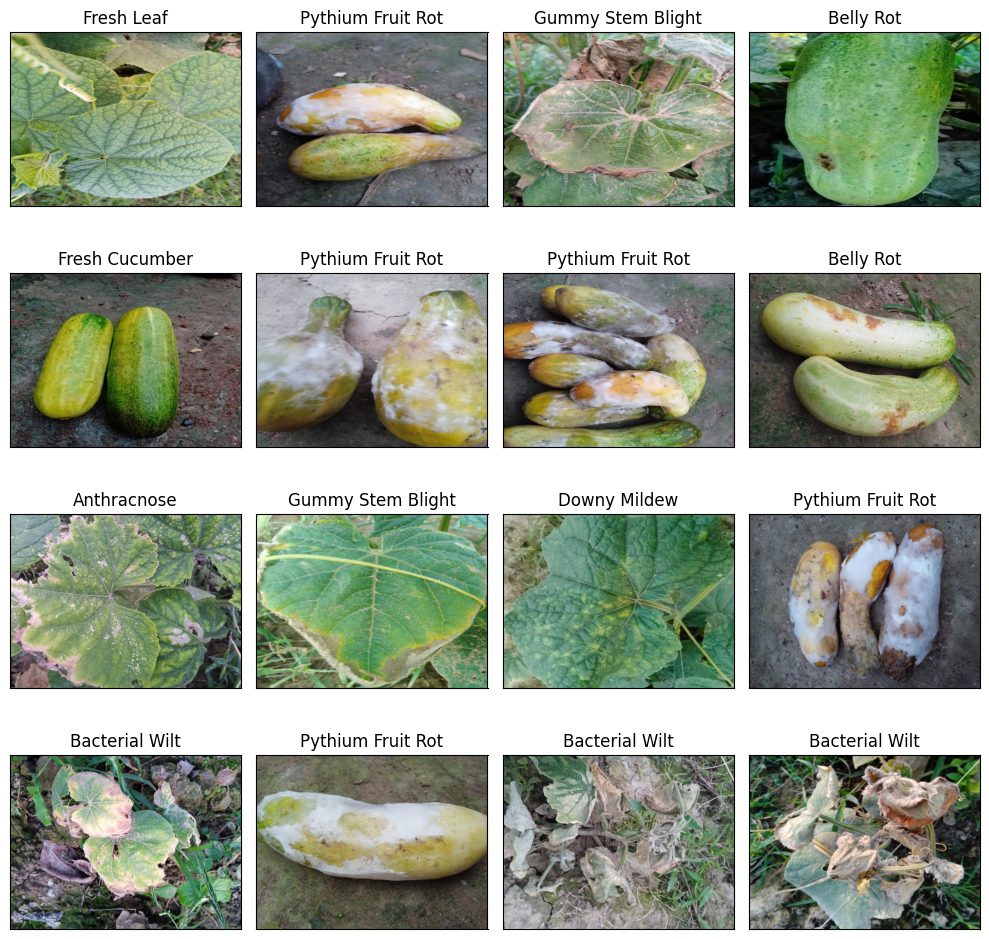

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (10, 10),
                         subplot_kw={'xticks': [], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
  ax.set_title(image_df.Label[random_index[i]])

plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, test_size = 0.05, shuffle = True, random_state = 42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split = 0.15
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col ='Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 16,
    shuffle=True,
    seed = 42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=16,
    shuffle=False
)

Found 1017 validated image filenames belonging to 8 classes.
Found 179 validated image filenames belonging to 8 classes.
Found 63 validated image filenames belonging to 8 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.125),
    layers.experimental.preprocessing.RandomContrast(0.1),
])

In [ ]:
# Load the pretrained model
pretrained_model=tf.keras.applications.efficientnet.EfficientNetB1(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path  = "grape_disease_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      save_best_only=True)

# Setup EarlyStopping callback to stop trainning if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss',
                                patience = 5,
                                restore_best_weights=True) # if val loss decrease for 3 epochs in a row, stop tranining

In [ ]:
# Train the model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
# x = GlobalAveragePooling2D()(pretrained_model.output)
# x = GlobalMaxPooling2D()(pretrained_model.output)
x = Dense(256, activation='relu')(pretrained_model.output)
# x = Dense(256, activation = 'relu')(x)
x = Dropout(0.45)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(8, activation='softmax')(x)
model = Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = Adam(0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'],
    )
for layer in model.layers[-20:]:
      if not isinstance(layer, layers.BatchNormalization):
          layer.trainable = True
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_10 (Rescaling)    (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_10[0][0]']        
 tion)                                                                                            
                                                                                                  
 rescaling_11 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_3[0][0]'

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data = val_images,
    validation_steps = len(val_images),
    epochs = 50,
    callbacks = [
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "cucumber_classification"),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: training_logs/cucumber_classification/20231201-161402
Epoch 1/50
64/64 [==============================] - 354s 5s/step - loss: 2.5499 - accuracy: 0.3196 - val_loss: 1.0591 - val_accuracy: 0.6257
Epoch 2/50
64/64 [==============================] - 130s 2s/step - loss: 1.5125 - accuracy: 0.4641 - val_loss: 0.8405 - val_accuracy: 0.6983
Epoch 3/50
64/64 [==============================] - 128s 2s/step - loss: 1.1983 - accuracy: 0.5644 - val_loss: 0.6974 - val_accuracy: 0.7933
Epoch 4/50
64/64 [==============================] - 126s 2s/step - loss: 0.9398 - accuracy: 0.6490 - val_loss: 0.5788 - val_accuracy: 0.7989
Epoch 5/50
64/64 [==============================] - 133s 2s/step - loss: 0.7930 - accuracy: 0.7011 - val_loss: 0.5016 - val_accuracy: 0.8268
Epoch 6/50
64/64 [==============================] - 127s 2s/step - loss: 0.6720 - accuracy: 0.7542 - val_loss: 0.4553 - val_accuracy: 0.8547
Epoch 7/50
64/64 [==============================] - 129s 2s/step - 

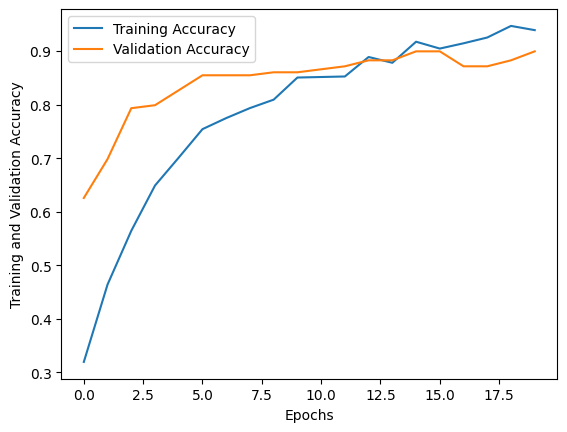

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label= "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Accuracy")
plt.legend()
plt.show()

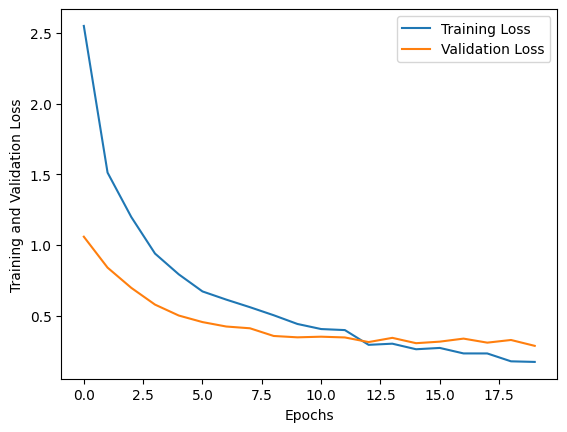

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label= "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Make predictions on test data
test_loss, test_accuracy =  model.evaluate(val_images, steps = len(val_images))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


12/12 [==============================] - 24s 2s/step - loss: 0.3059 - accuracy: 0.8994
Test Loss: 0.3059
Test Accuracy: 0.8994


In [ ]:
# Save the trained model
model.save("/content/drive/MyDrive/my_models/trained_model_cucu_efficientnetB1.h5")
print("Trained model saved as 'trained_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Trained model saved as 'trained_model.h5'


TypeError: ignored

In [ ]:
y_pred = model.predict(val_images)

12/12 [==============================] - 20s 1s/step


In [ ]:
# Get the class indices mapping from the training generator
class_indices = train_images.class_indices

# Invert the mapping to get class labels from indices
class_labels = {v: k for k, v in class_indices.items()}

# Get the labels of validation set
val_labels = val_images.classes

# Convert numeric labels to actual class labels
val_labels = [class_labels[label] for label in val_labels]

val_labels[:10]

['Gummy Stem Blight',
 'Fresh Cucumber',
 'Belly Rot',
 'Belly Rot',
 'Pythium Fruit Rot',
 'Anthracnose',
 'Fresh Leaf',
 'Bacterial Wilt',
 'Downy Mildew',
 'Downy Mildew']

In [ ]:
# Extract unique class labels
class_labels = image_df['Label'].unique()

# Display unique class labels
print("Class Labels:", class_labels)

Class Labels: ['Anthracnose' 'Bacterial Wilt' 'Belly Rot' 'Downy Mildew'
 'Fresh Cucumber' 'Fresh Leaf' 'Gummy Stem Blight' 'Pythium Fruit Rot']


In [ ]:
y_pred[:10]

array([[1.9788704e-10, 2.1368123e-08, 1.5424957e-10, 4.5937924e-11,
        3.3585415e-13, 5.5053032e-14, 7.1135298e-10, 9.9999994e-01],
       [7.1128450e-02, 1.2922984e-03, 1.7678726e-03, 8.7953597e-01,
        4.3288143e-03, 1.2031081e-03, 3.9020088e-02, 1.7233990e-03],
       [6.1003219e-02, 9.3002570e-01, 4.4443045e-04, 4.6658088e-04,
        7.0525522e-05, 6.8590738e-04, 6.9455872e-03, 3.5798945e-04],
       [1.6789124e-04, 1.7326305e-05, 2.4217827e-06, 2.3119670e-05,
        4.9555219e-06, 9.9975848e-01, 2.5641466e-05, 1.8980592e-07],
       [4.1601279e-01, 3.5586511e-03, 4.4334233e-03, 2.6584062e-01,
        7.3665483e-03, 1.1814518e-01, 1.8298586e-01, 1.6568784e-03],
       [7.8177312e-03, 5.5292770e-03, 2.2096255e-04, 9.6134704e-01,
        3.7741702e-04, 1.8903039e-02, 5.6766579e-03, 1.2775483e-04],
       [5.1374692e-01, 1.0245837e-02, 1.4672711e-03, 1.2474315e-02,
        3.8062711e-03, 1.5110931e-02, 4.4161007e-01, 1.5384402e-03],
       [2.0471114e-05, 5.5740806e-05, 6.4

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(val_images['Label'], y_pred)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TypeError: ignored